In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.transforms import ToPILImage, Resize
import torchvision.datasets as dset
to_img  = ToPILImage()
resize_img  = Resize(100)
def show_img(img):
    return resize_img(to_img(img))

cmap=plt.cm.tab10
c = cycler('color', cmap(np.linspace(0,1,10)))
plt.rcParams["axes.prop_cycle"] = c

%config InlineBackend.figure_format = 'retina'
%matplotlib notebook
%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [13]:
%matplotlib notebook
%matplotlib notebook

In [3]:
bs = 1

dataset = dset.ImageFolder(root='/scratch/rag394/data/gaussian_generator/',
                           transform=transforms.Compose([
                                   transforms.Grayscale(),
                                   transforms.Resize(28),
                                   transforms.CenterCrop(28),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,),(0.5,)),
                               ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs,
                                         shuffle=False, num_workers=32)

In [4]:
targets = pd.read_csv('/scratch/rag394/data/gaussian_generator/gaussian_parameters.csv').drop(['Unnamed: 0'], 1).values
targets = np.reshape(targets,[10000//bs,bs,4])
targets = Variable(torch.from_numpy(targets).type(torch.FloatTensor), requires_grad=False)
targets = targets.cuda()

In [5]:
class GaussianModel(nn.Module):
    def __init__(self):
        super(GaussianModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 4)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [15]:
%%time 

# model = GaussianModel()
# model.cuda()
# optimizer = torch.optim.RMSprop(model.parameters(),lr=1.0e-3)
# loss_fn = nn.MSELoss()

# print('batches in this run: {}\n\n'.format(10000//bs))
# total_loss = []
for epoch in range(100):
    epoch_loss = []
    for k, (data, _) in enumerate(dataloader):
        x_train = Variable(data.type(torch.FloatTensor), requires_grad=True).cuda()
        output = model(x_train)

        loss = loss_fn(output, targets[k,:,:])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.data[0])
        
#         if k % (10000//bs//5) == 0:
#             print('[{}:{}]  {}'.format(epoch,k,loss.data[0]))
            
    total_loss.append(np.mean(epoch_loss))
    print('\nepoch {} loss: {}'.format(epoch, total_loss[-1]))

<IPython.core.display.Javascript object>


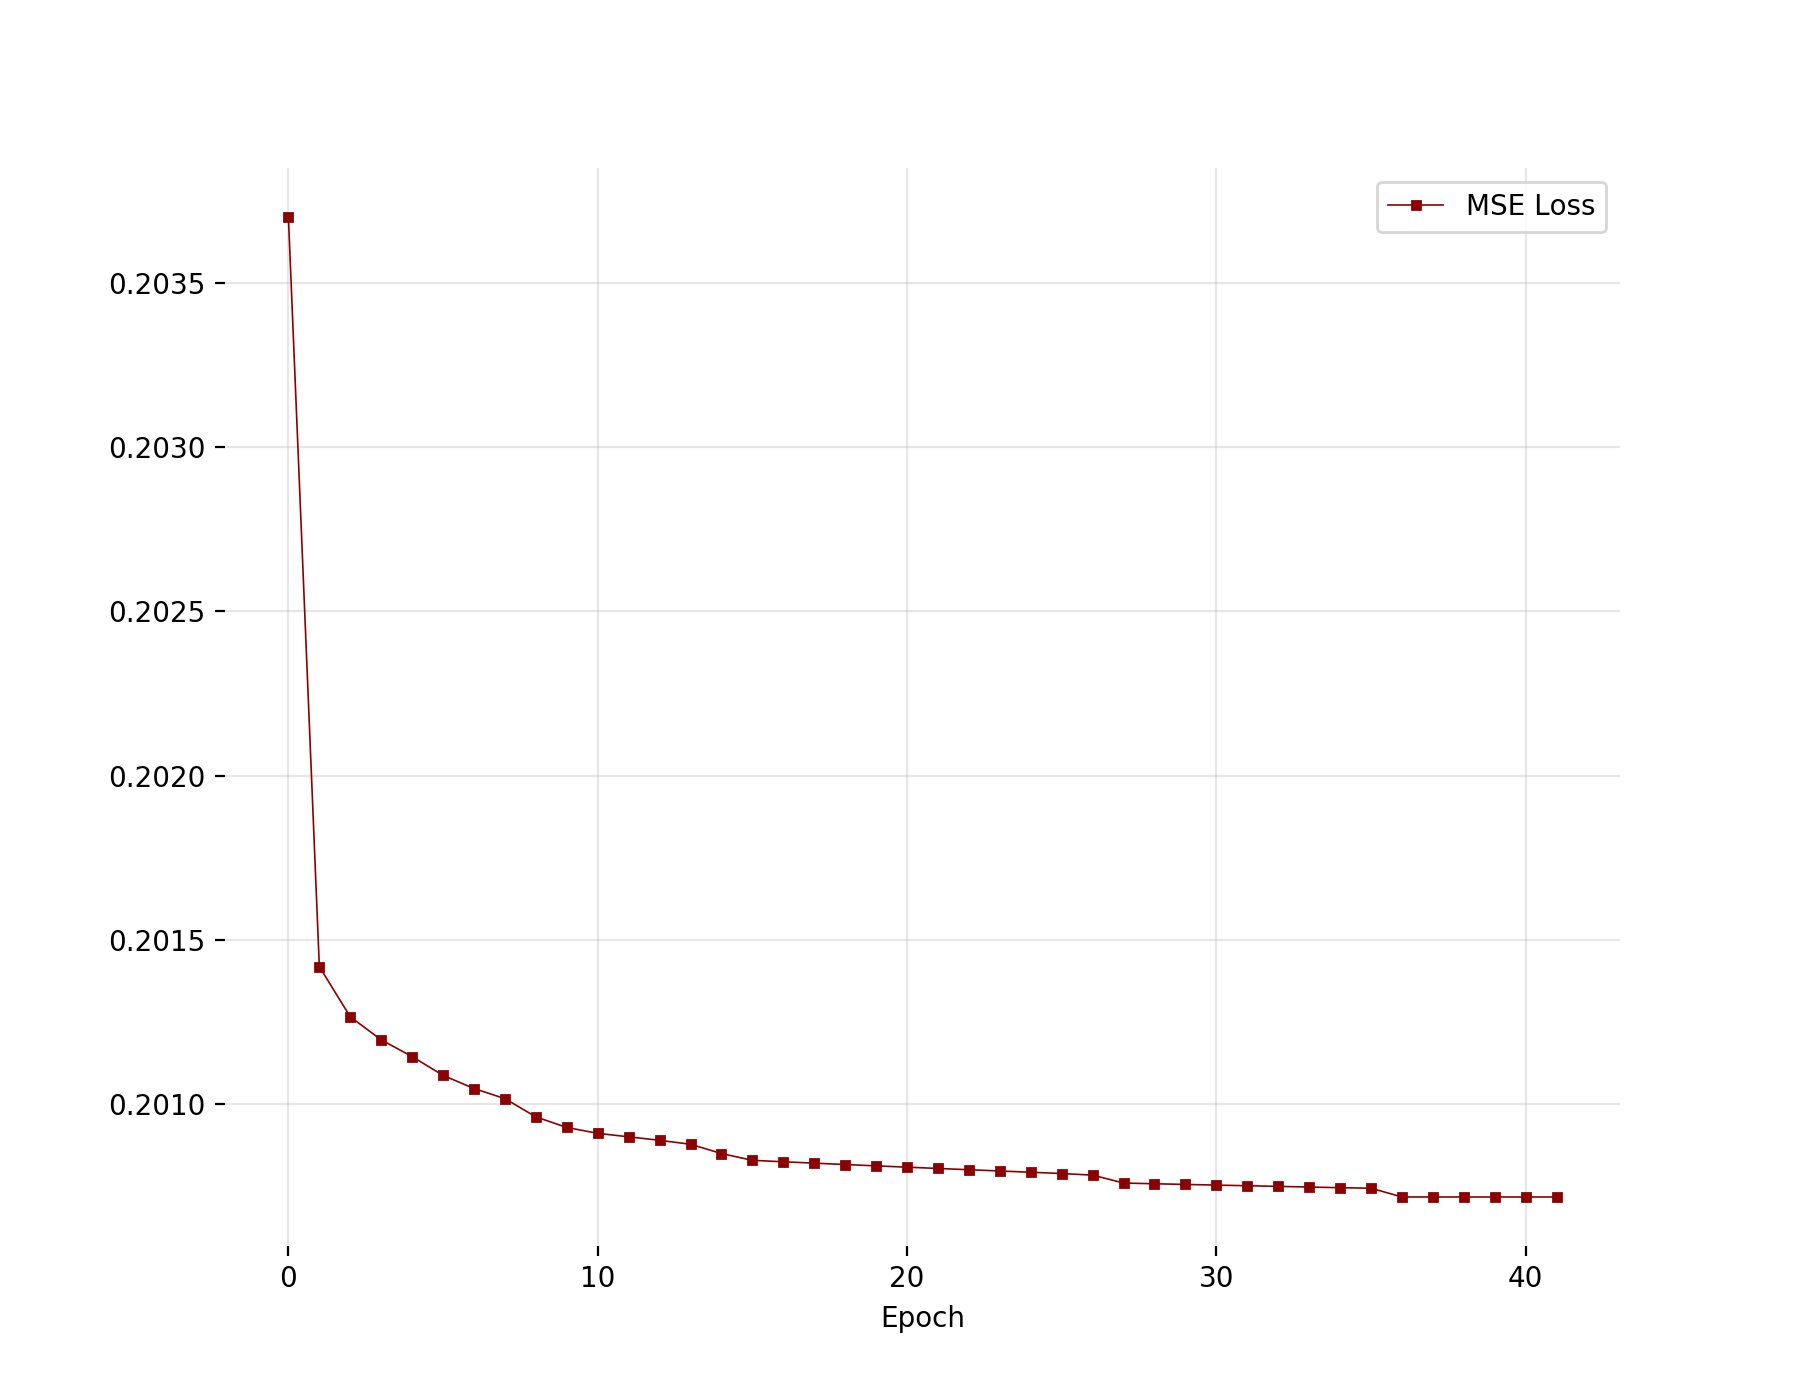

In [29]:
fig, ax = plt.subplots(figsize=(9,7))
pd.Series(total_loss, name='MSE Loss').plot(ax=ax,color='darkred', lw=0.6, marker='s', markersize=3., legend=True)
ax.grid(alpha=0.2)
ax.set_xlabel('Epoch')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_alpha(False)
ax.grid(alpha=0.3)